### Dados Macroeconômicos Seção 4 (01/1999 a 12/2024)

* PIB (Trimestral) - IBGE - sidrapy - Tabela 1621
* IPCA (Mensal)	- BCB - python-bcb - SGS 433
* IPCA (12 meses) - BCB - python-bcb - SGS 13522
* Selic Meta - BCB - python-bcb - SGS 432
* Expectativas - BCB - python-bcb - Endpoint Expectativas - Filtrar por Indicador='IPCA'

In [1]:
# !pip install python-bcb pandas matplotlib seaborn sidrapy

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bcb import sgs
from bcb import Expectativas
import sidrapy
import datetime

# Configurações de Estilo
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Parâmetros Globais
DATA_INICIAL = '1999-01-01'
DATA_FINAL = '2024-12-31'

# 2. Coleta de Dados via SGS (Sistema Gerenciador de Séries)
Coleta das séries de IPCA e Selic diretamente do Banco Central utilizando o módulo `sgs`.
- **433**: IPCA Mensal (%)
- **13522**: IPCA Acumulado 12 meses (%)
- **432**: Meta Selic (% a.a.)

In [2]:
def coleta_dados_sgs():
    print("Iniciando coleta de dados do SGS...")
    # O formato correto para sgs.get é {'Nome_da_Coluna': Codigo_SGS}
    codigos = {
        'IPCA_Mensal': 433,
        'IPCA_12m': 13522,
        'Selic_Meta': 432
    }
    
    dfs = []
    start_date = pd.to_datetime(DATA_INICIAL)
    end_date = pd.to_datetime(DATA_FINAL)
    
    # Loop para coletar em janelas de 5 anos para evitar erro de limite do BCB (max 10 anos para diárias)
    while start_date <= end_date:
        window_end = start_date + pd.DateOffset(years=5)
        if window_end > end_date:
            window_end = end_date
            
        print(f"Coletando chunk: {start_date.date()} até {window_end.date()}")
        
        try:
            df_chunk = sgs.get(codigos, start=start_date, end=window_end)
            if not df_chunk.empty:
                dfs.append(df_chunk)
        except Exception as e:
            print(f"Erro na coleta do chunk {start_date.date()}: {e}")
            
        start_date = window_end + pd.Timedelta(days=1)
    
    if dfs:
        df = pd.concat(dfs)
        df = df[~df.index.duplicated(keep='first')]
        print(f"Dados SGS coletados: {df.shape[0]} registros.")
        return df
    else:
        return pd.DataFrame()

df_sgs = coleta_dados_sgs()
df_sgs.head(), df_sgs.tail()

Iniciando coleta de dados do SGS...
Coletando chunk: 1999-01-01 até 2004-01-01
Coletando chunk: 2004-01-02 até 2009-01-02
Coletando chunk: 2009-01-03 até 2014-01-03
Coletando chunk: 2014-01-04 até 2019-01-04
Coletando chunk: 2019-01-05 até 2024-01-05
Coletando chunk: 2024-01-06 até 2024-12-31
Dados SGS coletados: 9437 registros.


(            IPCA_Mensal  IPCA_12m  Selic_Meta
 Date                                         
 1999-01-01         0.70      1.65         NaN
 1999-02-01         1.05      2.24         NaN
 1999-03-01         1.10      3.02         NaN
 1999-03-05          NaN       NaN        45.0
 1999-03-06          NaN       NaN        45.0,
             IPCA_Mensal  IPCA_12m  Selic_Meta
 Date                                         
 2024-12-27          NaN       NaN       12.25
 2024-12-28          NaN       NaN       12.25
 2024-12-29          NaN       NaN       12.25
 2024-12-30          NaN       NaN       12.25
 2024-12-31          NaN       NaN       12.25)

# 3. Coleta de Dados do PIB (IBGE)
Coleta da série do PIB trimestral utilizando a biblioteca `sidrapy`.
- **Tabela 1621**: Série encadeada do índice de volume trimestral com ajuste sazonal.
- **Variável 584**: Índice de volume trimestral com ajuste sazonal.
- **Setor**: PIB a preços de mercado.

In [3]:
def coleta_pib():
    print("Iniciando coleta de dados do PIB (IBGE)...")
    # Tabela 1621: Série encadeada do índice de volume trimestral com ajuste sazonal
    # Variável 584: Série encadeada do índice de volume trimestral com ajuste sazonal (Base: média de 1995 = 100)
    # Classificação 11255: Setores de atividade -> 90707: PIB a preços de mercado
    
    try:
        pib = sidrapy.get_table(
            table_code="1621",
            territorial_level="1",
            ibge_territorial_code="all",
            variable="584",
            classification="11255/90707",
            period="all"
        )
        
        # Limpeza e tratamento
        if pib.empty:
            print("Retorno vazio do sidrapy.")
            return pd.DataFrame()
            
        pib = pib.iloc[1:] # Remove a linha de cabeçalho/descrição
        pib = pib[['V', 'D2C']] # V: Valor, D2C: Trimestre (ex: 199601)
        pib.columns = ['PIB_Indice', 'Trimestre']
        
        # Converter valor para numérico
        pib['PIB_Indice'] = pd.to_numeric(pib['PIB_Indice'])
        
        # Converter Trimestre para Data (Primeiro dia do trimestre)
        # Formato IBGE: YYYY0Q (ex: 199901 -> 1º tri 1999)
        # 01 -> Mês 01, 02 -> Mês 04, 03 -> Mês 07, 04 -> Mês 10
        pib['Ano'] = pib['Trimestre'].str[:4]
        pib['Tri'] = pib['Trimestre'].str[-1].astype(int)
        pib['Mes'] = (pib['Tri'] * 3) - 2
        pib['Data'] = pd.to_datetime(pib['Ano'] + '-' + pib['Mes'].astype(str) + '-01')
        
        pib = pib.set_index('Data').sort_index()
        
        # Filtrar período
        pib = pib[(pib.index >= DATA_INICIAL) & (pib.index <= DATA_FINAL)]
        
        # Rebase para 1999=100 (Média de 1999 = 100)
        if not pib.empty:
            base_1999 = pib[pib.index.year == 1999]['PIB_Indice'].mean()
            pib['PIB_Indice'] = (pib['PIB_Indice'] / base_1999) * 100
        
        print(f"Dados PIB coletados: {pib.shape[0]} registros trimestrais.")
        return pib[['PIB_Indice']]
        
    except Exception as e:
        print(f"Erro na coleta do PIB: {e}")
        return pd.DataFrame()

df_pib = coleta_pib()
df_pib.head()

Iniciando coleta de dados do PIB (IBGE)...
Dados PIB coletados: 104 registros trimestrais.


,PIB_Indice
Data,
1999-01-01,99.263430
1999-04-01,99.779498
1999-07-01,99.770115
1999-10-01,101.186958
2000-01-01,102.266010


# 4. Coleta de Expectativas de Inflação (Focus)
Coleta das expectativas de mercado para o IPCA anual utilizando o módulo `Expectativas`.
O processo envolve:
1. Baixar dados do endpoint `ExpectativasMercadoAnuais`.
2. Filtrar pelo indicador IPCA.
3. Selecionar apenas as expectativas para o **ano corrente** (onde `DataReferencia` é igual ao ano da data de coleta).
4. Realizar uma reamostragem mensal calculando a média das expectativas diárias.

In [4]:
def coleta_expectativas():
    print("Iniciando coleta de Expectativas Focus...")
    em = Expectativas()
    ep = em.get_endpoint('ExpectativasMercadoAnuais')
    
    # Filtra por IPCA e data inicial para otimizar a consulta
    try:
        df_focus = ep.query().filter(ep.Indicador == 'IPCA').filter(ep.Data >= DATA_INICIAL).collect()
        
        # Converter Data para datetime
        df_focus['Data'] = pd.to_datetime(df_focus['Data'])
        df_focus['DataReferencia'] = df_focus['DataReferencia'].astype(int)
        
        # Filtrar período de análise (garantia adicional)
        df_focus = df_focus[(df_focus['Data'] >= DATA_INICIAL) & (df_focus['Data'] <= DATA_FINAL)]
        
        # Filtrar expectativa para o ano corrente
        # Lógica: Queremos saber qual era a expectativa para 2023 em 2023, etc.
        df_focus = df_focus[df_focus['DataReferencia'] == df_focus['Data'].dt.year]
        
        # Selecionar colunas e renomear
        df_focus = df_focus[['Data', 'Media']]
        df_focus = df_focus.rename(columns={'Media': 'Expectativa_IPCA_AnoCorrente'})
        
        # Reamostragem mensal (Média mensal das expectativas diárias)
        # 'ME' é o alias para Month End no pandas mais recente. Use 'M' se der erro em versões antigas.
        df_focus = df_focus.set_index('Data').resample('ME').mean()
        
        print(f"Dados Focus processados: {df_focus.shape[0]} registros mensais.")
        return df_focus
        
    except Exception as e:
        print(f"Erro na coleta do Focus: {e}")
        return pd.DataFrame()

df_focus = coleta_expectativas()
df_focus.head(), df_focus.tail()

Iniciando coleta de Expectativas Focus...
Dados Focus processados: 300 registros mensais.


(            Expectativa_IPCA_AnoCorrente
 Data                                    
 2000-01-31                      6.933810
 2000-02-29                      6.835238
 2000-03-31                      6.600476
 2000-04-30                      6.432632
 2000-05-31                      6.246818,
             Expectativa_IPCA_AnoCorrente
 Data                                    
 2024-08-31                      4.242536
 2024-09-30                      4.357445
 2024-10-31                      4.480109
 2024-11-30                      4.642787
 2024-12-31                      4.867495)

# 5. Tratamento e Consolidação
Unificação das bases de dados do SGS, PIB e Focus em um único DataFrame com frequência mensal.
Realiza-se o alinhamento das datas (início do mês) e tratamento de dados faltantes.
Para o PIB (trimestral), os dados serão repetidos ou interpolados para frequência mensal (Forward Fill).

In [5]:
def consolidar_dados(df_sgs, df_focus, df_pib):
    print("Consolidando dados...")
    
    # Ajuste de índice do Focus para o primeiro dia do mês para alinhar com SGS
    df_focus_adj = df_focus.copy()
    df_focus_adj.index = df_focus_adj.index.to_period('M').to_timestamp()
    
    # Merge SGS e Focus
    df_final = pd.merge(df_sgs, df_focus_adj, left_index=True, right_index=True, how='outer')
    
    # Merge PIB
    # O PIB é trimestral. Ao fazer o merge, teremos NaNs nos meses sem dado.
    # Vamos usar forward fill para preencher os meses dentro do trimestre (ou interpolação linear se preferir)
    # Aqui usaremos ffill para manter o valor do trimestre até o próximo.
    df_final = pd.merge(df_final, df_pib, left_index=True, right_index=True, how='outer')
    
    # Filtro final de datas para garantir o range solicitado
    df_final = df_final[(df_final.index >= DATA_INICIAL) & (df_final.index <= DATA_FINAL)]
    
    # Preenchimento de dados faltantes
    # Primeiro ffill para preencher PIB e eventuais buracos pequenos
    df_final = df_final.ffill()
    
    print(f"Dataset final consolidado: {df_final.shape}")
    return df_final

df_economico = consolidar_dados(df_sgs, df_focus, df_pib)
df_economico.tail()

Consolidando dados...
Dataset final consolidado: (9437, 5)


,IPCA_Mensal,IPCA_12m,Selic_Meta,Expectativa_IPCA_AnoCorrente,PIB_Indice
2024-12-27,0.52,4.83,12.25,4.867495,179.26343
2024-12-28,0.52,4.83,12.25,4.867495,179.26343
2024-12-29,0.52,4.83,12.25,4.867495,179.26343
2024-12-30,0.52,4.83,12.25,4.867495,179.26343
2024-12-31,0.52,4.83,12.25,4.867495,179.26343


# 6. Visualização Exploratória
Geração de gráficos para análise visual das séries temporais.
- **Gráfico 1**: Comparação entre IPCA acumulado em 12 meses e a Meta Selic.
- **Gráfico 2**: Evolução das expectativas de inflação para o ano corrente.
- **Gráfico 3**: Evolução do PIB (Índice de Volume).

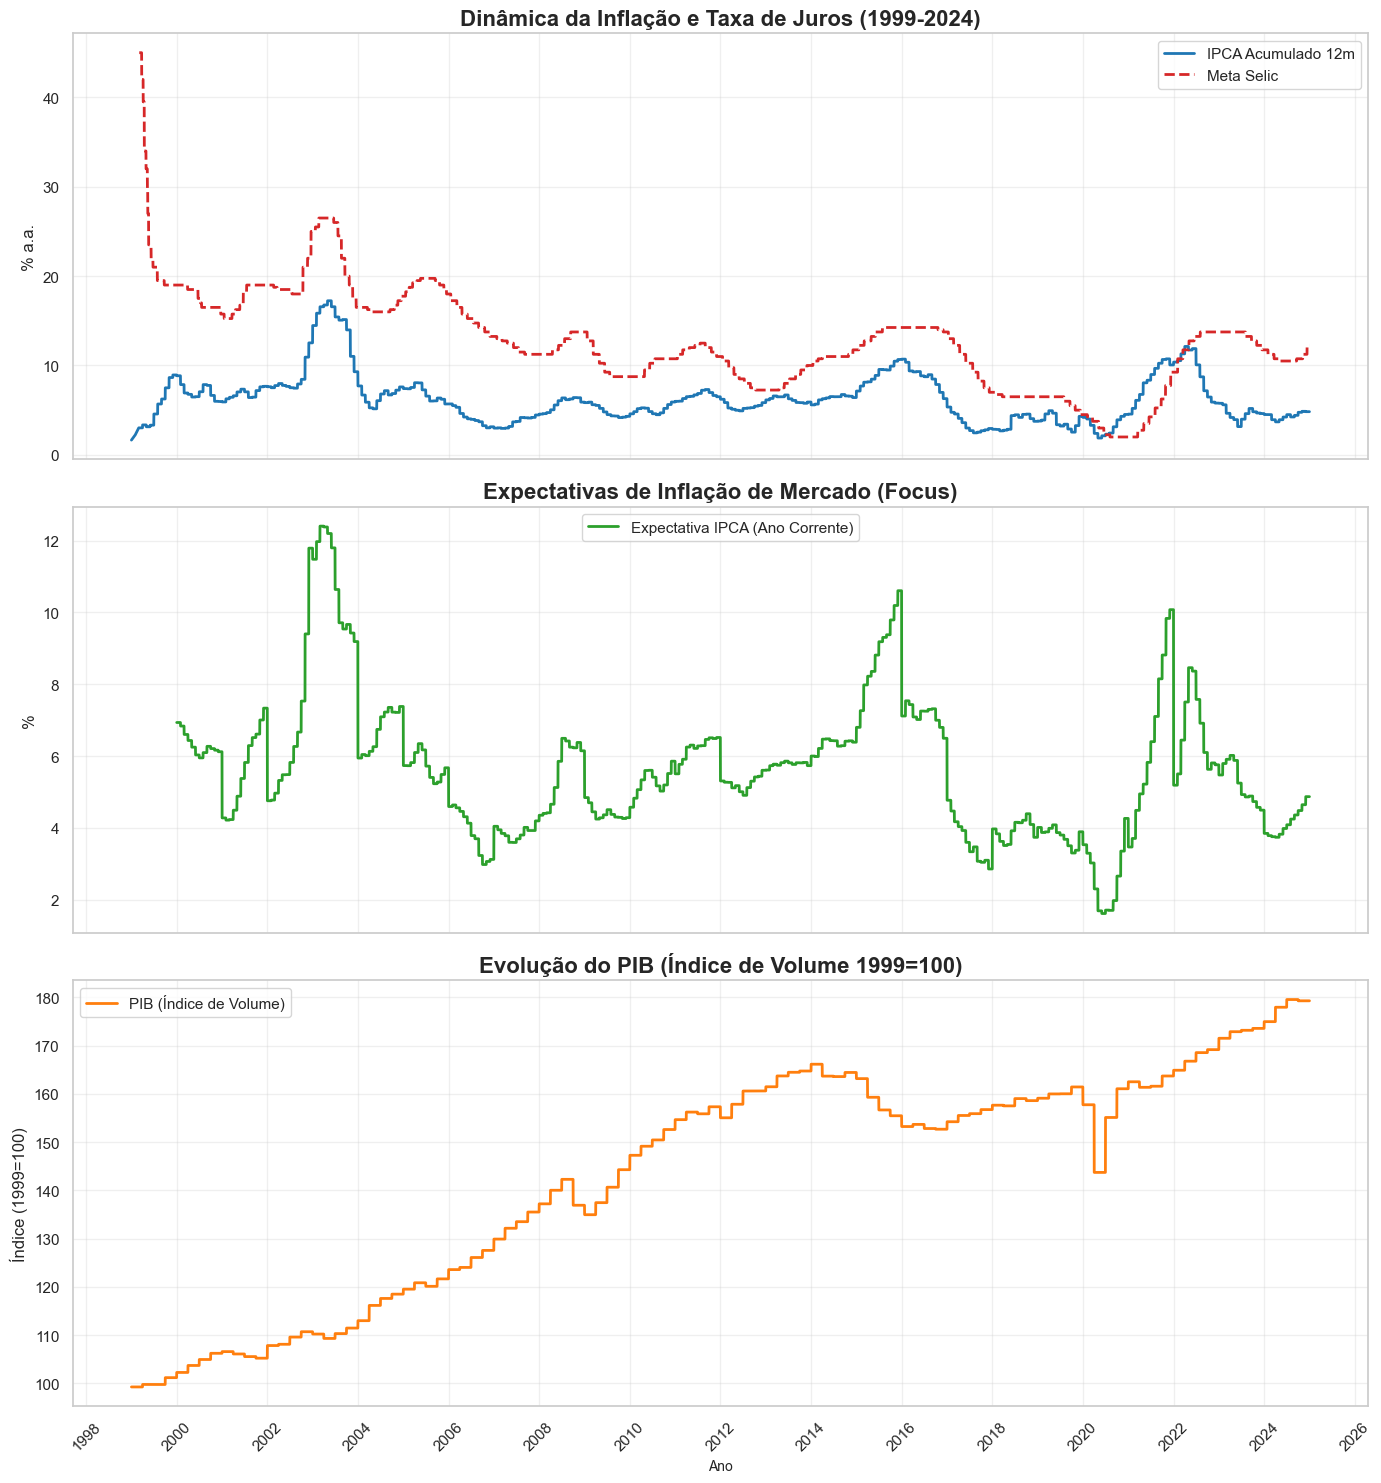

In [6]:
import matplotlib.dates as mdates

def plotar_dados(df):
    fig, axes = plt.subplots(3, 1, figsize=(14, 15), sharex=True)
    
    # Gráfico 1: IPCA 12m vs Selic
    sns.lineplot(data=df, x=df.index, y='IPCA_12m', ax=axes[0], label='IPCA Acumulado 12m', color='#1f77b4', linewidth=2)
    sns.lineplot(data=df, x=df.index, y='Selic_Meta', ax=axes[0], label='Meta Selic', color='#d62728', linestyle='--', linewidth=2)
    
    axes[0].set_title('Dinâmica da Inflação e Taxa de Juros (1999-2024)', fontsize=16, fontweight='bold')
    axes[0].set_ylabel('% a.a.', fontsize=12)
    axes[0].legend(loc='upper right', frameon=True)
    axes[0].grid(True, alpha=0.3)
    
    # Gráfico 2: Expectativas
    sns.lineplot(data=df, x=df.index, y='Expectativa_IPCA_AnoCorrente', ax=axes[1], label='Expectativa IPCA (Ano Corrente)', color='#2ca02c', linewidth=2)
    
    axes[1].set_title('Expectativas de Inflação de Mercado (Focus)', fontsize=16, fontweight='bold')
    axes[1].set_ylabel('%', fontsize=12)
    axes[1].legend(loc='upper center', frameon=True)
    axes[1].grid(True, alpha=0.3)
    
    # Gráfico 3: PIB
    sns.lineplot(data=df, x=df.index, y='PIB_Indice', ax=axes[2], label='PIB (Índice de Volume)', color='#ff7f0e', linewidth=2)
    
    axes[2].set_title('Evolução do PIB (Índice de Volume 1999=100)', fontsize=16, fontweight='bold')
    axes[2].set_ylabel('Índice (1999=100)', fontsize=12)
    axes[2].set_xlabel('Ano', fontsize=10)
    axes[2].legend(loc='upper left', frameon=True)
    axes[2].grid(True, alpha=0.3)
    
    # Configuração do Eixo X (Anos de 2 em 2)
    axes[2].xaxis.set_major_locator(mdates.YearLocator(2))
    axes[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

plotar_dados(df_economico)